# Plotting

Now that we've covered working with geospatial data and working with projections, we're ready to make some maps of our own.

<!--
``geoplot`` is cartographic plotting for the 90% of use cases. What does that mean in practice?

The dominant dataset format in the current Python ecosystem is the `CSV` (or something `CSV`-like, like an `HDF5` store), and the dominant geospatial datatype within such datasets is the simple `(X, Y)` coordinate. This is because at its deepest level, the data that we create and consume tends to be point data: a police response at an identifiable intersection; an ad click from a geolocated IP address; a 311 complaint recorded from such-and-such address. Even when data isn't *really* pointwise, oftentimes it can summarized succintly by pretending that it is: take hurriances, for example, which the United States NOAA releases (in its simplest form) as coordinate center observations taken at one-hour intervals.

The few times when it's not one coordinate, it tends to be *two* coordinates (`(X_1, Y_1)`; `(X_2, Y_2)`) in a network of some kind. An analysis of an urban bikeshare program, for example, might include network data on station-to-station route popularity, for example.

Polygons are the other popular geospatial scheme. NYPD reports on New York City crime trends, for example, are aggregated at the police precinct level, and data collected in terms of points can easily be aggregated into geographic areas (doubly so if a categorical variable like "Census Tract" or "State" is in the fold).

That is not to say that all data comes in the form of points or polygons, of course. There are all sorts of data types not adequetly described by either, things like MRI scans or astronomical data or road network utilization. "Points and polygons" are merely the simplest and easiest-to-use geospatial formats; hence, the ones that the modern "data scientist", in the troperific sense of the word, tends to run into; and hence, the focus of this library.

And with that pontification out the way, the rest of this page will explore the finer points of practical ``geoplot``. We'll introduce the plot types as we go along, not dithering too long on anything in particular: to get the full picture, read the API documentation! Along the way we'll examine useful fundamentals that apply to the library as a whole.
-->

Suppose I'm interested in the distribution of accidents in the city. Let's grab the data...

In [4]:
import sys; sys.path.insert(0, '../../')  # ignore this
import geopandas as gpd

import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline

In [14]:
import shapely

collisions = pd.read_csv("../../data/nyc_collisions/NYPD_Motor_Vehicle_Collisions_2016.csv", index_col=0)
collisions = collisions[collisions['LOCATION'].notnull()]
collision_points = collisions.apply(lambda srs: shapely.geometry.Point(srs['LONGITUDE'], srs['LATITUDE']),
                                    axis='columns')
collisions = gpd.GeoDataFrame(collisions, geometry=collision_points)

In [16]:
import pandas as pd; pd.set_option('max_columns', 6)  # Unclutter display.
collisions.head()

,DATE,TIME,BOROUGH,...,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry
1,04/16/2016,4:13,NaN,...,NaN,NaN,POINT (-73.95005740000001 40.767373)
3,04/16/2016,4:30,BRONX,...,NaN,NaN,POINT (-73.90903969999999 40.8626793)
4,04/16/2016,4:30,BROOKLYN,...,NaN,NaN,POINT (-73.96127509999999 40.7165078)
5,04/16/2016,4:30,MANHATTAN,...,NaN,NaN,POINT (-73.9877686 40.7497883)
6,04/16/2016,4:50,NaN,...,NaN,NaN,POINT (-73.96049620000002 40.7024019)


We'll start with a ``polyplot``. This is a very simple plot type that merely repeats whatever geometry you put into it.

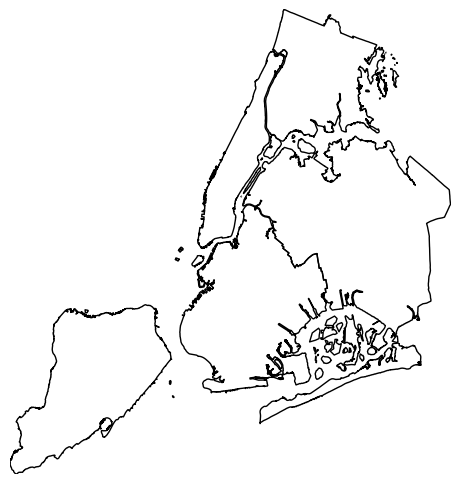

In [5]:
gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())

We can use ``pointplot`` to examine where fatal collisions have occurred.

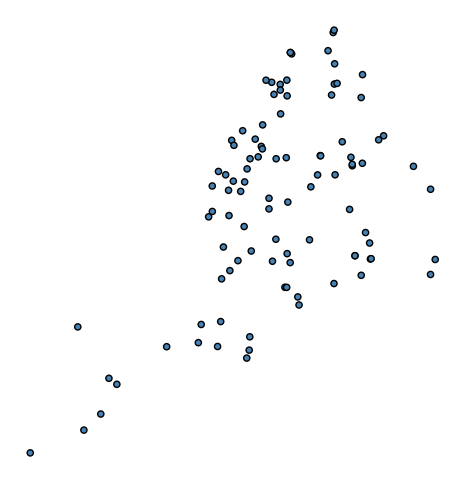

In [21]:
fatal_collisions = collisions[collisions['NUMBER OF PERSONS KILLED'] > 0]
gplt.pointplot(fatal_collisions, projection=gcrs.AlbersEqualArea())

Hmm. This isn't very helpful; we're missing geographic context! Let's add another layer to our map: a ``polyplot`` for the city's five boroughs.

In [9]:
boroughs = gpd.read_file("../../data/nyc_boroughs/boroughs.geojson")
boroughs

,BoroCode,BoroName,Shape_Area,Shape_Leng,geometry
0,5,Staten Island,1.623853e+09,330385.03697,(POLYGON ((-74.05050806403247 40.5664220341608...
1,4,Queens,3.049947e+09,861038.47930,(POLYGON ((-73.83668274106708 40.5949466970158...
2,3,Brooklyn,1.959432e+09,726568.94634,(POLYGON ((-73.8670614947212 40.58208797679338...
3,1,Manhattan,6.364422e+08,358532.95642,(POLYGON ((-74.01092841268033 40.6844914725429...
4,2,Bronx,1.186804e+09,464517.89055,(POLYGON ((-73.89680883223775 40.7958084451597...


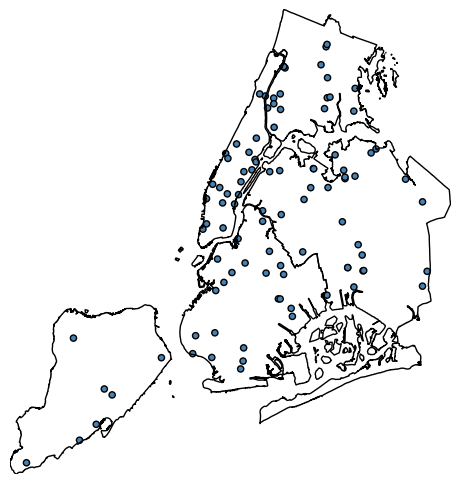

In [28]:
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())
gplt.pointplot(fatal_collisions, projection=gcrs.AlbersEqualArea(), ax=ax)

Great. Let's now use the ``pointplot`` ``hue`` and ``scale`` parameters to emphasize accidents by number of persons killed and time of day. Can we find any discernable patterns?

In [39]:
collision_times = pd.to_datetime(fatal_collisions['TIME']).map(lambda dt: 600 * dt.hour + 60 * dt.minute + dt.second)

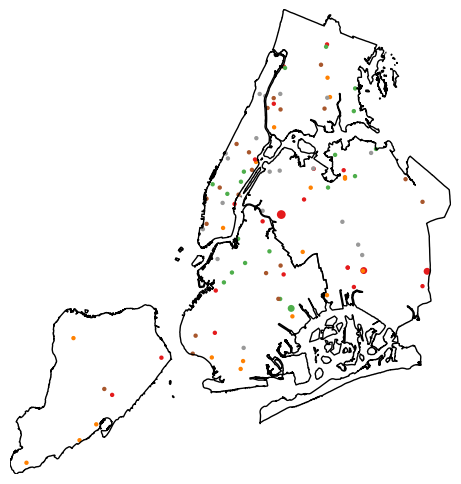

In [65]:
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())
gplt.pointplot(fatal_collisions, hue=collision_times, 
               scale="NUMBER OF PERSONS KILLED",
               projection=gcrs.AlbersEqualArea(), 
               linewidth=0,
               ax=ax)

Hard to tell. Let's add a ``legend``, make the circles bigger (with ``limits``), and pick a progressive color scale (with ``cmap``). The following cell also demonstrates the large number of styling choices at our disposal:

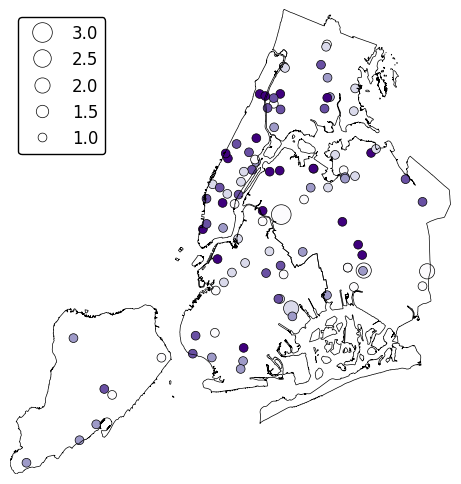

In [75]:
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), linewidth=0.5)
gplt.pointplot(fatal_collisions, hue=collision_times, 
               scale="NUMBER OF PERSONS KILLED",
               projection=gcrs.AlbersEqualArea(), 
               linewidth=0.5, alpha=1,
               limits=(2, 10),
               cmap='Purples',
               legend=True, legend_kwargs={'loc': 'upper left'}, legend_var='scale',
               ax=ax)

It looks like most fatal collisions only result in one fatality, and that fatal accidents occur throughout the day.

In [ ]:
collision_times

In [8]:
import pandas as pd; pd.set_option('max_columns', 6)  # Unclutter display.
manhattan_buildings = gpd.read_file('../../data/manhattan_mappluto/MN_Dcp_Mappinglot.shp')
manhattan_buildings.head()

,BLOCK,BORO,CREATED_BY,...,Shape_Area,Shape_Leng,geometry
0,20009,1,None,...,10289.237892,836.495687,"POLYGON ((986519.6798000038 200244.1201999933,..."
1,20031,1,None,...,8943.539985,478.609196,"POLYGON ((992017.6599999964 216103.8700000048,..."
2,20027,1,None,...,10156.610383,486.181920,"POLYGON ((991564.0900000036 215278.3798999935,..."
3,20012,1,None,...,7657.969093,357.345276,"POLYGON ((986364.6000999957 201496.4998999983,..."
4,20067,1,None,...,9171.078777,479.281556,"POLYGON ((995870.7099999934 223069.0699999928,..."


## To be continued...

This tutorial is still a work in progress. For now I suggest reading the documentation in the API Reference.